So I have written this stuff to simulate nuclei from series of gaussian blobs. The resulting function has many parameters. I've also come up with a comparison metric (which may not be perfect but seems to at least be plausible) for comparing real data to simulated data: comparing the histograms of scale-space representations of the data. What I would like to do is fit the parameters of simulation function to each dataset. The big problem is that this is all super slow. The fitting seems like a bit of a non-starter. I came up with a set of potential solutions to use together:

1. Learn to use Savio to get off my local machine. This is done.

2. Instead of fitting, precompute histograms for a wide range of parameters and compare real datasets to those.

3. Parallelize the code.

I think I can do everything except part 3, which I am still struggling with. I'm going to try to use Dask to do this. Here goes...

OK, I'm going to start simple. First, simulate some data with a single varying parameter. If I can call this in parallel that will be a win.

In [1]:
# Import my packages.
import flymovie as fm
import os
import copy
import scipy
import skimage as ski
import scipy.ndimage as ndi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
import dask
from time import sleep

from math import sqrt
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

# Activate package autoload.
%load_ext autoreload
%autoreload 2

In [12]:
from flymovie import mesh_like

def make_mask():
    mask = np.zeros((20, 800, 800)) # 40, 1000, 1000
    z, i, j = mesh_like(mask, 3)
    z_midpoint = int(mask.shape[0] / 2)
    rad = 50
    nuc_id = 1
    for i_center in range(100, mask.shape[1], 200):
        for j_center in range(100, mask.shape[2], 200):
            mask[(((z - z_midpoint) ** 2) + ((i - i_center) ** 2) + ((j - j_center) ** 2)) < (rad ** 2)] = nuc_id
            nuc_id += 1
    return mask

mask = make_mask()
fm.viewer(mask, 4)

interactive(children=(Dropdown(description='Color', index=1, options=('inferno', 'cividis', 'Gators', 'plasma'…

In [20]:
from flymovie.fitting import gaussian3d

def make_3d_gauss_box(intensity, sigma_z, sigma_ij, z_winlen, ij_winlen):
    d1 = scipy.signal.gaussian(ij_winlen, sigma_ij)
    d2 = np.outer(d1, d1)
    z_1dvector = scipy.signal.gaussian(z_winlen, sigma_z)
    d3 = d2 * np.expand_dims(z_1dvector, axis=(1,2))
    return intensity * d3

def simulate_nuclei(nucmask, bg_mean, bg_var, blob_intensity_mean, blob_intensity_var, blob_radius_mean, blob_radius_var, blob_number, z_ij_ratio=0.5):
    """Simulate the distribution of fluorescence signal within nuclei in a supplied mask.
    
    Args:
        nucmask: ndarray
            3D mask (binary or label) defining positions of nuclei
        bg_mean: numeric
            The mean value of the nuclear background signal
        bg_var: numeric
            Variance of the nuclear background signal
        blob_intensity_mean: numeric
            Mean fluorescence intensity of gaussian "blobs"
        blob_intensity_var: numeric
            Variance of the gaussian blob intensity
        blob_radius_mean: numeric
            Mean radius, in pixels, of gaussian blobs
        blob_radius_var: numeric
            Variance of blob radius
        blob_number: int
            Number of gaussian blobs per nucleus

    Returns:
        simstack: ndarray
            Stack of same shape as nucmask containing simulated data.
    """
    def make_3d_gaussian_inabox(intensity, sigma_z, sigma_ij, z_winlen, ij_winlen):
        """Make a 3D gaussian signal within a box of defined size.
        
        I used trial and error to find vectorized ways to multiply 1D numpy
        vectors (generated from 1D gaussian functions) together to produce
        a proper 3D gaussian."""
        d1 = scipy.signal.gaussian(ij_winlen, sigma_ij)
        d2 = np.outer(d1, d1)
        z_1dvector = scipy.signal.gaussian(z_winlen, sigma_z)
        d3 = d2 * np.expand_dims(z_1dvector, axis=(1,2))
        return intensity * d3

    def add_box_to_stack(stack, box, coords):
        """Add pixel values from a supplied "box" to a stack at a position 
        centered at supplied coordinates."""
        # Initialize arrays to store the start and end coordinates for the 
        # stack and the box in each dimension.
        box_starts = []
        box_ends = []
        stack_starts = []
        stack_ends = []
        # For each dimension, find the start and stop positions for the box and 
        # the stack to be centered at coords; handle the cases where the supplied 
        # coordinates and box size will result in trying to assign positions 
        # outside the stack.
        for dim in range(0, 3):
            start = coords[dim] - int(box.shape[dim] / 2)
            end = coords[dim] + int(box.shape[dim] / 2) + 1
            if start < 0:
                stack_starts.append(0)
                stack_ends.append(end + start)
                box_starts.append(-start)
                box_ends.append(box.shape[dim] + start)
            elif end > stack.shape[dim]:
                stack_starts.append(start)
                stack_ends.append(stack.shape[dim])
                box_starts.append(0)
                box_ends.append(box.shape[dim] + stack.shape[dim] - end)
            else:
                stack_starts.append(start)
                stack_ends.append(end)
                box_starts.append(0)
                box_ends.append(box.shape[dim])
        # Ensure that the shapes of the subsection of the stack to add to
        # and the box to add are the same. If so, add box values to stack.
        substack_shape = stack[stack_starts[0]:stack_ends[0], stack_starts[1]:stack_ends[1], stack_starts[2]:stack_ends[2]].shape
        box_to_add = box[box_starts[0]:box_ends[0], box_starts[1]:box_ends[1], box_starts[2]:box_ends[2]]
        if substack_shape == box_to_add.shape:
            stack[stack_starts[0]:stack_ends[0], stack_starts[1]:stack_ends[1], stack_starts[2]:stack_ends[2]] += box_to_add
        else:
            raise ValueError('Shape of box and stack section not equal')

    # Must be odd
    z_windowlen = 5
    ij_windowlen = 21
    # Initialize stack with just nuclear backgrounds.
    bg_stack = np.random.normal(bg_mean, bg_var, size=nucmask.shape)
    simstack = np.where(nucmask, bg_stack, 0)
    # Go through each nucleus, add specified blobs.
    for nuc_id in np.unique(nucmask)[1:]:
        # Get the set of coordinates for this nucleus.
        nuc_coords = np.where(nucmask == nuc_id)
        nuc_numpixels = len(nuc_coords[0])
        for n in range(0, blob_number):
            # Get blob radii in ij (lateral) and z (axial) dimensions.
            r_ij = np.random.normal(blob_radius_mean, blob_radius_var)
            r_z = r_ij * z_ij_ratio
            # Get randomly-generated intensity.
            intensity = np.random.normal(blob_intensity_mean, blob_intensity_var)
            # Select a random coordinat in the nucleus.
            rand_pixel_num = np.random.randint(0, nuc_numpixels - 1)
            z, i, j = nuc_coords[0][rand_pixel_num], nuc_coords[1][rand_pixel_num], nuc_coords[2][rand_pixel_num]
            #gaussian_function = gaussian3d(z, i, j, intensity, r_z, r_ij, r_ij)
            # Make a 3D "box" with values from specified 3D gaussian function, then
            # add that to the stack in a way that is relatively fast.
            box = make_3d_gaussian_inabox(intensity, r_z, r_ij, z_windowlen, ij_windowlen)
            add_box_to_stack(simstack, box, (z, i, j))
    return simstack            
    


In [21]:
%%time
d = []
for a in range(0,2):
    d.append(simulate(nucmask=mask, bg_mean=100, bg_var=2, blob_intensity_mean=200, blob_intensity_var=10, blob_radius_mean=3, blob_radius_var=5, blob_number=100))

CPU times: user 2.8 s, sys: 99.6 ms, total: 2.9 s
Wall time: 2.79 s


In [6]:
from dask.distributed import Client, LocalCluster

client = Client(n_workers=4)

distributed.diskutils - INFO - Found stale lock file and directory '/Users/michaelstadler/Bioinformatics/Projects/rpb1/notebooks_active/dask-worker-space/worker-cz4w37ah', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/michaelstadler/Bioinformatics/Projects/rpb1/notebooks_active/dask-worker-space/worker-ebwdteuf', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/michaelstadler/Bioinformatics/Projects/rpb1/notebooks_active/dask-worker-space/worker-zizhpg0m', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/michaelstadler/Bioinformatics/Projects/rpb1/notebooks_active/dask-worker-space/worker-xr3ibnfs', purging


In [14]:
%%time
b = []
for blob_num in range(0,10):
    b.append(dask.delayed(simulate)(nucmask=mask, bg_mean=100, bg_var=2, blob_intensity_mean=200, 
        blob_intensity_var=10, blob_radius_mean=3, blob_radius_var=5, blob_number=100))

c = dask.compute(b)

CPU times: user 1.22 s, sys: 2.35 s, total: 3.57 s
Wall time: 7.84 s


In [19]:
%%time
b = []
with LocalCluster(n_workers=4):
    #for blob_intensity_mean in range(100,110):
    for blob_num in range(100,500):
        b.append(dask.delayed(simulate)(nucmask=mask, bg_mean=100, bg_var=2, blob_intensity_mean=blob_intensity_mean, 
            blob_intensity_var=10, blob_radius_mean=3, blob_radius_var=5, blob_number=blob_num))

    c = dask.compute(b)
    

/Users/michaelstadler/opt/anaconda3/envs/im2/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54069 instead
  warnings.warn(


KeyboardInterrupt: 

In [32]:
fm.viewer(c[0][0], 4)

interactive(children=(Dropdown(description='Color', index=8, options=('inferno', 'Reds', 'prism', 'Gators', 'g…

In [62]:
def test():
    sleep(0.25)
    return(1)

In [64]:
%%time
d = []
for a in range(100,105):
    d.append(test())

CPU times: user 70.7 ms, sys: 17.8 ms, total: 88.5 ms
Wall time: 1.26 s


In [68]:
%%time
b = []
for a in range(100,110):
    b.append(dask.delayed(simulate)(nucmask=mask, bg_mean=100, bg_var=2, blob_intensity_mean=200, 
        blob_intensity_var=10, blob_radius_mean=3, blob_radius_var=5, blob_number=a))

c = dask.compute(b)

CPU times: user 72.4 ms, sys: 50.5 ms, total: 123 ms
Wall time: 222 ms


In [2]:
from flymovie.simulate_blobs import make_dummy_mask, simulate_blobs
mask = make_dummy_mask()
sim = simulate_blobs(mask, 10, 1, 100, 10, 3,1,5)

In [10]:
import time
time.time()

1633030437.7102451

(array([1.2769331e+07, 1.1273000e+04, 7.9560000e+03, 5.3210000e+03,
        3.3700000e+03, 1.9180000e+03, 6.5200000e+02, 1.2300000e+02,
        4.3000000e+01, 1.3000000e+01]),
 array([  0.        ,  16.65383583,  33.30767166,  49.96150749,
         66.61534331,  83.26917914,  99.92301497, 116.5768508 ,
        133.23068663, 149.88452246, 166.53835828]),
 <BarContainer object of 10 artists>)

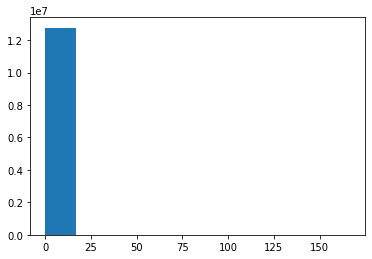

In [44]:
plt.hist(sim.flatten())

In [46]:
ss = fm.simulate_blobs.make_scalespace(sim, np.arange(0,10))

In [53]:
fm.viewer(ss,5)

interactive(children=(Dropdown(description='Color', index=1, options=('magma', 'cividis', 'gray', 'inferno', '…

In [56]:
def make_scalespace_hist(scalespace, mask=None, numbins=100, histrange=(0,25)):
    """Make a 2D histogram of a scalespace representation of an image stack.
    
    Args:
        scalespace: ndarray
            Scalespace representation of image stack (scale in dimension 0)
        make: ndarray
            (optional) Mask for values to be included in histogram calculation
        numbins: int
            Number of bins to use for histogram
        histrange: (int, int)
            Range of values to be included in histogram
    
    Returns:
        hist_data: ndarray
            Histogram data for each sigma level of input data. Dimensions
            are number of sigmas x numbins
        
    """
    def get_pixel_vals(stack, mask):
        """Create flattened array of values in mask foreground of image 
        stack."""
        if mask is not None:
            return stack[np.where(mask)]
        else:
            return stack.flatten()
    # Initialize histogram data with 0s.
    hist_data = np.zeros(tuple([scalespace.shape[0], numbins]))
    # Make histogram from each sigma level, add to hist_data.
    for s in range(0, scalespace.shape[0]):
        vals = get_pixel_vals(scalespace[s], mask)
        hist_ = np.histogram(vals, bins=numbins, range=histrange)[0]
        hist_data[s] = hist_
    
    return hist_data

b = make_scalespace_hist(ss, mask, )

(10, 100)


In [57]:
fm.viewer(b)

interactive(children=(Dropdown(description='Color', index=1, options=('magma', 'cividis', 'gray', 'inferno', '…

In [116]:
mask.shape

(20, 800, 800)

In [118]:
from flymovie.simulate_blobs import simulate_blobs, make_scalespace_representation, make_scalespace_hist
def make_parameter_hist_data(bg_mean_range, bg_var_range, blob_intensity_mean_range, 
    blob_intensity_var_range, blob_radius_mean_range, blob_radius_var_range, 
    blob_number_range, z_ij_ratio=2, sigmas=[0,0.5,1,1.5,2,4,6], numbins=100, 
    histrange=(0,25), zdim=40, idim=800, jdim=800, nuc_spacing=200, nuc_rad=50):
    """Simulate blobs with a range of parameters, record scale-space histograms.
    
    Args:
        bg_mean_range: iterable
            Range of values for the nuclear baground mean
        bg_var_range= iterable
            Range of values for the nuclear background variance
        blob_intensity_mean_range: iterable
            Range of values for the blob intensity mean
        blob_intensity_var_range: iterable
            Range of values for the blob intensity variance
        blob_radius_mean_range: iterable
            Range of values for the blob radius mean
        blob_radius_var_range: iterable
            Range of values for the blob radius variance
        blob_number_range: iterable
            Range of values for the number of blobs per nucleuc
        z_ij_ratio: numeric
            Ratio of the size of voxels in z to ji dimensions
        sigmas: iterable
            Sigma values to use in constructing scale-space representations
            of simulated stacks.
        numbins: int
            Number of bins for histogram
        histrange: tuple of ints
            End points for histogram values
        zdim: int
            Size of simulated stack in pixels in z.
        idim: int
            Size of simulated stack in pixels in i
        jdim: int
            Size of simulated stack in pixels in j
        nuc_spacing: int
            The spacing, in pixels, between nuclei in i and j.
        nuc_rad: int
            Radius, in pixels, of simulated nuclei.

    Returns:
        data_: delayed list
            Dask delayed object, must be computed using dask.compute(data_).
            Each list item is the outcome of a simulation. Items are tuples.
            First (0) item is a list of simulation parameters:
                0: bg_mean 
                1: bg_var 
                2: blob_intensity_mean 
                3: blob_intensity_var 
                4: blob_radius_mean 
                5: blob_radius_var
                6: blob_number
            Second item (1) is the 2D histogram of the scale-space representation  
    """
    mask = make_dummy_mask(zdim, idim, jdim, nuc_spacing, nuc_rad)
    data_ = []
    for bg_mean in bg_mean_range:
        for bg_var in bg_var_range:
            for blob_intensity_mean in blob_intensity_mean_range:
                for blob_intensity_var in blob_intensity_var_range:
                    for blob_radius_mean in blob_radius_mean_range:
                        for blob_radius_var in blob_radius_var_range:
                            for blob_number in blob_number_range:
                                """
                                # Non-delayed in case needed.
                                simstack = simulate_blobs(mask, bg_mean, bg_var, blob_intensity_mean, 
                                    blob_intensity_var, blob_radius_mean, blob_radius_var, blob_number, 
                                    z_ij_ratio)
                                scalespace = make_scalespace_representation(simstack, sigmas)
                                hist_ = make_scalespace_hist(scalespace, mask, numbins, histrange)
                                """
                                #"""
                                simstack = dask.delayed(simulate_blobs)(mask, bg_mean, bg_var, blob_intensity_mean, 
                                    blob_intensity_var, blob_radius_mean, blob_radius_var, blob_number, 
                                    z_ij_ratio)
                                scalespace = dask.delayed(make_scalespace_representation)(simstack, sigmas)
                                hist_ = dask.delayed(make_scalespace_hist)(scalespace, mask, numbins, histrange)
                                #"""
                                params = [bg_mean, bg_var, blob_intensity_mean, blob_intensity_var, blob_radius_mean, 
                                    blob_radius_var, blob_number]
                                data_.append((params, hist_))
    return data_    




In [122]:
bg_mean_range=np.arange(50,150,50)
bg_var_range=[1]
blob_intensity_mean_range=[200]
blob_intensity_var_range=[10]
blob_radius_mean_range=[1,2,3,4,5]
blob_radius_var_range=[1]
blob_number_range=[100]

data_delayed = grandsim(bg_mean_range, bg_var_range, blob_intensity_mean_range, 
    blob_intensity_var_range, blob_radius_mean_range, blob_radius_var_range, 
    blob_number_range)

data = dask.compute(data_delayed)

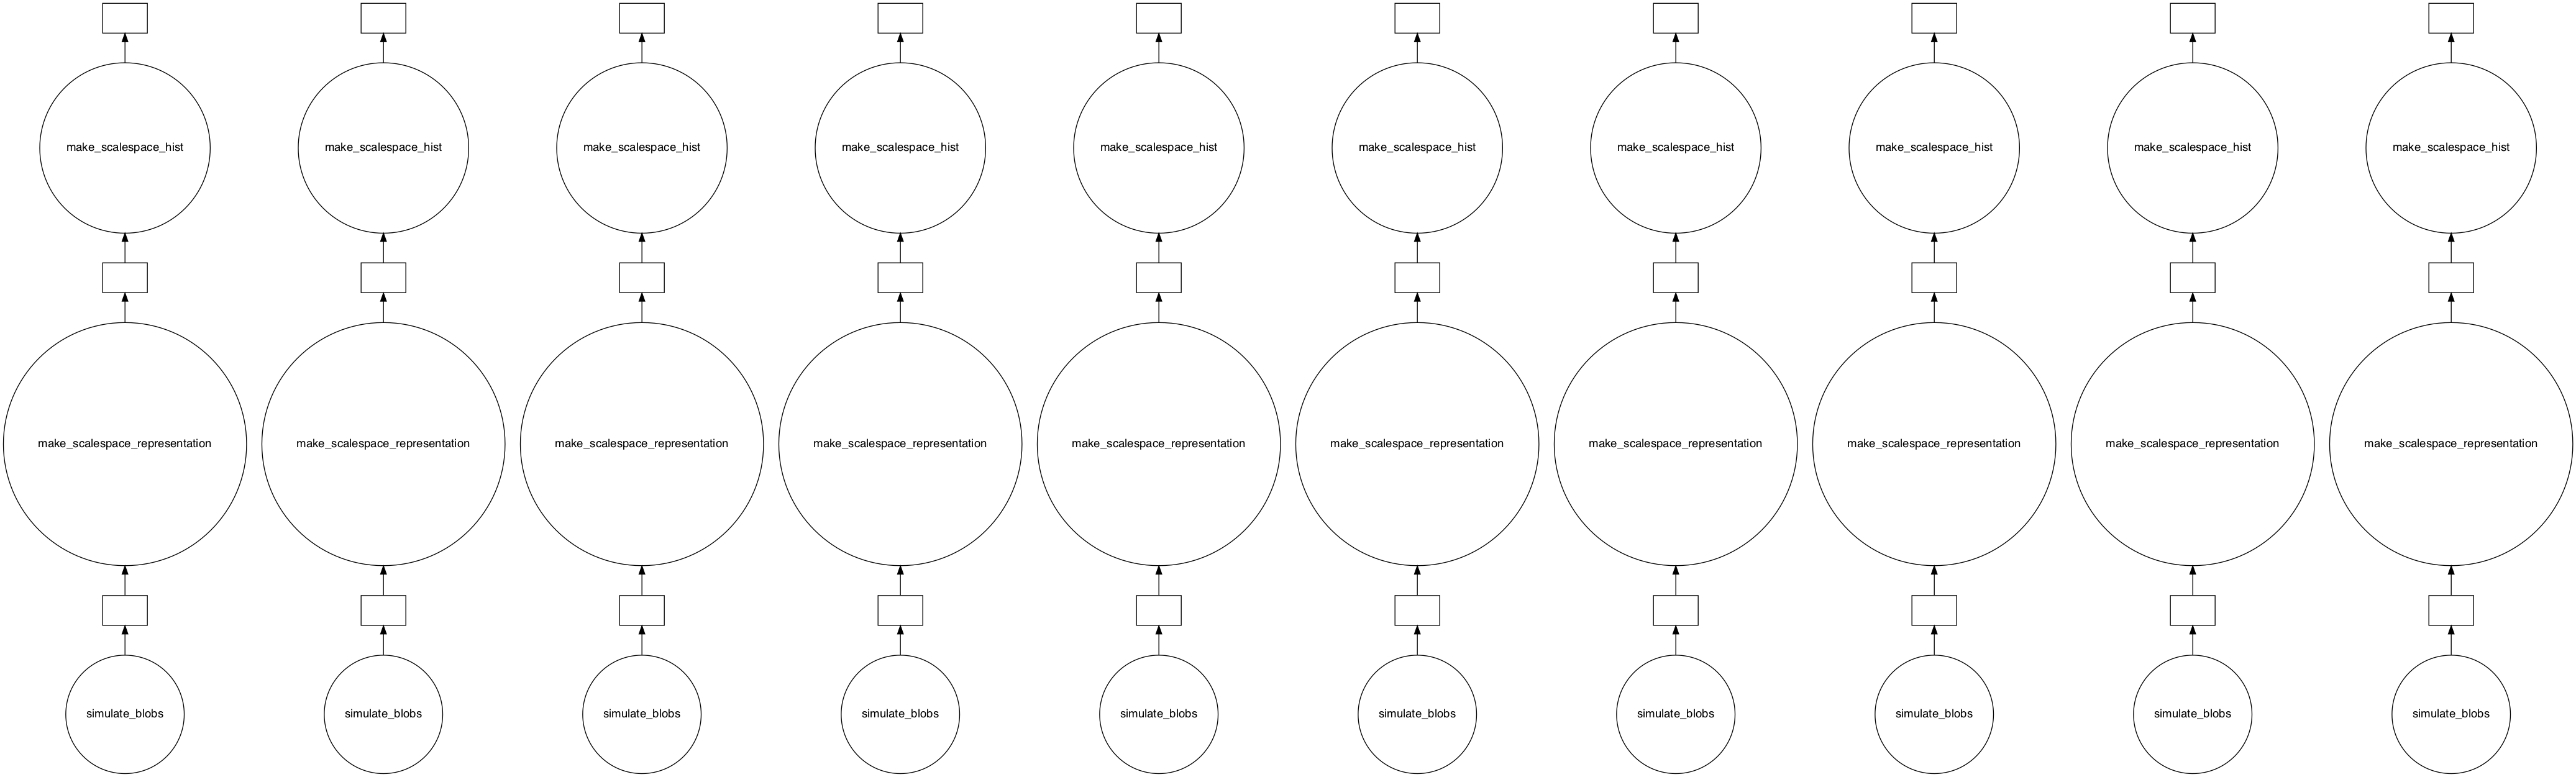

In [113]:
a = grandsim(mask, bg_mean_range=np.arange(50,150,50), bg_var_range=[1], blob_intensity_mean_range=[200], 
    blob_intensity_var_range=[10], blob_radius_mean_range=[1,2,3,4,5], blob_radius_var_range=[1], 
    blob_number_range=[100])

b = dask.compute(a)

In [50]:
im1 = np.random.rand(20,20)
im2 = np.random.rand(20,20) * 100

In [53]:
import cv2 as cv
hist1 = np.histogram(im1.flatten())[0].astype('float32')
hist2 = np.histogram(im2.flatten())[0].astype('float32')
#hist1 = hist1 / np.sum(hist1)
#hist2 = hist2 / np.sum(hist2)
cv.compareHist(hist1, hist2, method=cv.HISTCMP_BHATTACHARYYA)

0.1162512743631909

In [55]:
def bhat(h1, h2):
    hist1 = h1 / np.sum(h1)
    hist2 = h2 / np.sum(h2)
    sum_ = 0
    for i in range(0, len(hist1)):
        sum_ += np.sqrt(hist1[i] * hist2[i])
    print(sum_)
    return -np.log(sum_)
bhat(hist1, hist2)

0.9864856377243996


0.013606512445113583

How to compare these 2D histograms? We could do a comparison of each 1D histogram (CV). The thing is the histogram comparison normalizes to make a probability distribution. This is fine but it means it will basically only be a comparison of shapes and we will lose all intensity information. For that reason I think I'll start with a simple absolute comparison. Flatten the 2d array and do a pure distance calculation. I'll try a few and see if it makes any difference.

In [61]:
import scipy
def histogram_dist(hist1, hist2, method='manhattan'):
    if method == 'manhattan':
        dist = scipy.spatial.distance.cityblock(hist1.flatten(), hist2.flatten())
    if method == 'euclidean':
        dist = scipy.spatial.distance.euclidean(hist1.flatten(), hist2.flatten())
    if method == 'minkowski':
        dist = scipy.spatial.distance.minkowski(hist1.flatten(), hist2.flatten())
    return dist

histogram_dist(hist1, hist2, method='manhattan')

106.0

In [62]:
def compare_hist_all(im, mask, sim_data, numbins=100, histrange=(0,25), method='manhattan'):
    scalespace = make_scalespace_representation(im)
    hist_ = make_scalespace_hist(scalespace, mask, numbins, histrange)
    distances = np.zeros((len(sim_data),8))
    for i in range(0, len(sim_data)):
        params, hist_sim = sim_data[i]
        dist = histogram_dist(hist_, hist_sim)
        distances[i] = np.concatenate([params, dist])
    return distances


(array([  5.,  29.,  89., 177., 217., 241., 142.,  70.,  25.,   5.]),
 array([ 6923.07885083,  7550.65497716,  8178.23110348,  8805.80722981,
         9433.38335614, 10060.95948247, 10688.53560879, 11316.11173512,
        11943.68786145, 12571.26398778, 13198.8401141 ]),
 <BarContainer object of 10 artists>)

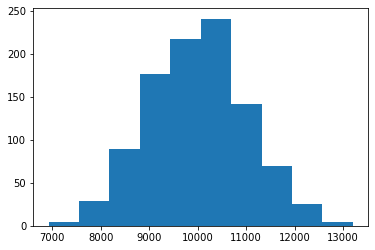

In [66]:
plt.hist(np.random.normal(10_000, 1000, 1000))

In [2]:
import flymovie as fm
b = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/histparams_test2.pkl')

In [8]:
mask = fm.make_dummy_mask()

In [14]:
sim = fm.simulate_blobs(mask)

In [36]:
def make_scalespace_1dhist(stack, sigmas, mask, numbins=100, histrange=(0,66000)):
    def get_pixel_vals(stack, mask):
        """Create flattened array of values in mask foreground of image 
        stack."""
        if mask is not None:
            return stack[np.where(mask)]
        else:
            return stack.flatten()
    hist_ = []
    for sigma in sigmas:
        stack_filtered = ndi.gaussian_filter(stack, sigma)
        vals = get_pixel_vals(stack_filtered, mask)
        hist_thissigma = np.histogram(vals, bins=numbins, range=histrange)[0]
        hist_ = np.concatenate([hist_, hist_thissigma])
    return hist_

In [37]:
hist1d = make_scalespace_1dhist(sim, [1,2,3], mask)

In [39]:
ss = fm.make_scalespace_representation(sim, [1,2,3])
hist_ = fm.make_scalespace_hist(ss, mask, numbins=100, histrange=(0,66000))

In [40]:
np.array_equal(hist_.flatten(), hist1d)

True

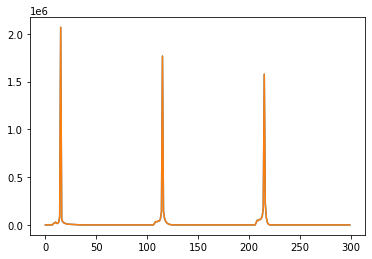

In [41]:
plt.plot(hist_.flatten())
plt.plot(hist1d)

In [61]:
def make_scalespace_2dhist(stack, sigmas, mask, numbins=100, histrange=(0,66000)):
    def get_pixel_vals(stack, mask):
        """Create flattened array of values in mask foreground of image 
        stack."""
        if mask is not None:
            return stack[np.where(mask)]
        else:
            return stack.flatten()
    hist_ = np.ndarray((0, numbins))
    for sigma in sigmas:
        stack_filtered = ndi.gaussian_filter(stack, sigma)
        vals = get_pixel_vals(stack_filtered, mask)
        hist_thissigma = np.histogram(vals, bins=numbins, range=histrange)[0]
        hist_ = np.vstack([hist_, hist_thissigma])
    return hist_

In [62]:
hist2d = make_scalespace_2dhist(sim, [1,2,3], mask)

In [64]:
np.array_equal(hist2d+1, hist_)

False

In [56]:
np.vstack([c,a])

array([[1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4]])

In [2]:
bg_mean_range=[10_000]
bg_var_range=[1000]
blob_intensity_mean_range=np.arange(17_000, 23_000, 1000)
blob_intensity_var_range=[2000]
blob_radius_mean_range=[0.5]
blob_radius_var_range=[0.25]
blob_number_range=np.arange(50,500,50)
from dask.distributed import Client
if __name__ == "__main__":
    client = Client(n_workers=1)

data_ = fm.make_parameter_hist_data(bg_mean_range, bg_var_range, blob_intensity_mean_range, 
    blob_intensity_var_range, blob_radius_mean_range, blob_radius_var_range, 
    blob_number_range, z_ij_ratio=2, sigmas=[0,0.5,1,1.5,2,4,6], numbins=100, 
    histrange=(0,25), zdim=20, idim=600, jdim=600, nuc_spacing=200, nuc_rad=50)

#data2 = dask.compute(data_)

distributed.diskutils - INFO - Found stale lock file and directory '/Users/michaelstadler/Bioinformatics/Projects/rpb1/notebooks_active/dask-worker-space/worker-gvdhyv5k', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/michaelstadler/Bioinformatics/Projects/rpb1/notebooks_active/dask-worker-space/worker-zyz721_7', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/michaelstadler/Bioinformatics/Projects/rpb1/notebooks_active/dask-worker-space/worker-3pbs4jxa', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/michaelstadler/Bioinformatics/Projects/rpb1/notebooks_active/dask-worker-space/worker-1z1gccph', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/michaelstadler/Bioinformatics/Projects/rpb1/notebooks_active/dask-worker-space/worker-k0ljc9pk', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/michaelstadler/Bioinforma

KeyboardInterrupt: 

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/michaelstadler/opt/anaconda3/envs/im2/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/michaelstadler/opt/anaconda3/envs/im2/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/michaelstadler/opt/anaconda3/envs/im2/lib/python3.9/site-packages/distributed/__init__.py", line 2, in <module>
    from . import widgets  # isort:skip; load distributed widgets second
  File "/Users/michaelstadler/opt/anaconda3/envs/im2/lib/python3.9/site-packages/distributed/widgets/__init__.py", line 5, in <module>
    from ..utils import key_split
  File "/Users/michaelstadler/opt/anaconda3/envs/im2/lib/python3.9/site-packages/distributed/utils.py", line 29, in <module>
    import click
  File "/Users/michaelstadler/opt/anaconda3/envs/im2/lib/python3.9/site-packages/click/__init__.

In [5]:
bg_mean_range=[10_000]
bg_var_range=[1000]
blob_intensity_mean_range=[20000]
blob_intensity_var_range=[2000]
blob_radius_mean_range=[0.5]
blob_radius_var_range=[0.25]
blob_number_range=np.arange(50,500,50)
from dask.distributed import Client
if __name__ == "__main__":
    client = Client(n_workers=4)

data_ = fm.make_parameter_hist_data(bg_mean_range, bg_var_range, blob_intensity_mean_range, 
    blob_intensity_var_range, blob_radius_mean_range, blob_radius_var_range, 
    blob_number_range, z_ij_ratio=2, sigmas=[0,0.5,1,1.5,2,4,6], numbins=100, 
    histrange=(0,25), zdim=20, idim=600, jdim=600, nuc_spacing=200, nuc_rad=50)

dask.compute(data_)
client.close()

distributed.diskutils - INFO - Found stale lock file and directory '/Users/michaelstadler/Bioinformatics/Projects/rpb1/notebooks_active/dask-worker-space/worker-4vmq_ufu', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/michaelstadler/Bioinformatics/Projects/rpb1/notebooks_active/dask-worker-space/worker-sgt3ay2j', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/michaelstadler/Bioinformatics/Projects/rpb1/notebooks_active/dask-worker-space/worker-smhh1640', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/michaelstadler/Bioinformatics/Projects/rpb1/notebooks_active/dask-worker-space/worker-3sf6x12u', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/michaelstadler/Bioinformatics/Projects/rpb1/notebooks_active/dask-worker-space/worker-o4zju8lc', purging
/Users/michaelstadler/opt/anaconda3/envs/im2/lib/python3.9/site-packages/distributed/worker.py:3862:

In [54]:
nucs = pd.read_csv('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/nucsfiltered.csv')
tracks = pd.read_csv('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/tracks.csv')
spots = pd.read_csv('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/spots.csv')



In [2]:
from dataclasses import dataclass

def make_tables_from_arivis(trackfile, nucfile, spotfile):
    @dataclass
    class DataCont:
        nuc_all: pd.DataFrame
        spot_all: pd.DataFrame
        nuc: pd.DataFrame
        spot: pd.DataFrame

    tracks = pd.read_csv(trackfile)
    nucs = pd.read_csv(nucfile)
    spots = pd.read_csv(spotfile)

    data = []
    track_num = 0
    for index, row in tracks.iterrows():
        data.append({})
        for child_id in row['Children Ids'].split(','):
            nuc_data = nucs[nucs['Id'] == int(child_id)]
            if nuc_data.shape[0] != 0:
                nuc_id = int(nuc_data['Id'])
                if 'nuc' not in data[track_num]:
                    data[track_num]['nuc'] = nuc_data
                else:
                    data[track_num]['nuc'] = pd.concat([data[track_num]['nuc'], nuc_data]) 
                
                spot_data = spots[spots['Parent Ids'] == nuc_id]
                if spot_data.shape[0] != 0:
                    
                    if 'spot' not in data[track_num]:
                        data[track_num]['spot'] = spot_data
                    else:
                        data[track_num]['spot'] = pd.concat([data[track_num]['spot'], spot_data]) 
        track_num += 1
        
    selected = ['First, Time Point', 'X (px), Center of Bounding Box',	'Y (px), Center of Bounding Box',	'Z (px), Center of Bounding Box',
        'Min, Intensities #1',	'Max, Intensities #1',	'Mean, Intensities #1',	'Sum, Intensities #1',	'SD, Intensities #1',
        'Min, Intensities #2',	'Max, Intensities #2',	'Mean, Intensities #2',	'Sum, Intensities #2',	'SD, Intensities #2']
    selected_simple = ['t', 'x', 'y', 'z', 'min_intensity_1',	'max_intensity_1',	'mean_intensity_1',	'sum_intensity_1',	'sd_intensity_1',
        'min_intensity_2',	'max_intensity_2',	'mean_intensity_2',	'sum_intensity_2',	'sd_intensity_2']
    data_final = []
    
    for i in range(0, len(data)):
        if 'spot' in data[i]:
            nuc = data[i]['nuc']
            spot = data[i]['spot']
            nuc_selected = nuc[selected]
            spot_selected = spot[selected]
            nuc_selected.columns = selected_simple
            spot_selected.columns = selected_simple
            data_final.append(DataCont(nuc, spot, nuc_selected, spot_selected))
            
    return data_final
            
nucfile = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/nucsfiltered.csv'
trackfile = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/tracks.csv'
spotfile = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/spots.csv'

#dataf = make_tables_from_arivis(trackfile, nucfile, spotfile)

In [3]:
dataf = fm.make_tables_from_arivis(trackfile, nucfile, spotfile)

In [4]:
dataf[2].nuc

,t,x,y,z,min_intensity_1,max_intensity_1,mean_intensity_1,sum_intensity_1,sd_intensity_1,min_intensity_2,max_intensity_2,mean_intensity_2,sum_intensity_2,sd_intensity_2
3,1,619.0,98.5,7.5,69,40383,6112.940125,269941323,2989.672426,42,17754,1099.614371,48557871,1065.858701
16,2,617.0,88.5,8.0,74,39815,6069.622896,284501434,2904.357760,41,22514,1088.127728,51003811,1111.894054
35,3,620.0,75.5,9.0,58,36572,5996.554163,302801999,2907.360256,41,23815,1074.118485,54238687,1067.219515
54,4,619.5,71.5,9.0,65,39773,5958.815796,303369271,2882.686300,42,24007,1067.572332,54351175,1094.041547
70,5,615.5,67.0,9.0,77,40262,5979.544049,297488296,2882.972104,41,20529,1071.288256,53297662,1088.477386
108,6,615.0,64.0,9.5,77,36466,5997.752716,325713959,2850.936298,37,27576,1032.569016,56074693,1053.539682
133,7,619.5,56.5,9.5,71,38517,5809.730813,308996343,2782.339055,40,25953,1019.340879,54214664,1072.360604
159,8,624.0,51.5,9.5,70,36598,5767.227222,315922940,2779.948916,38,19790,1001.947699,54885693,1036.543115
195,9,624.0,46.0,9.5,69,42624,5777.992759,306435846,2753.118735,40,20186,996.339945,52840889,1015.543464
201,10,625.5,38.0,10.0,69,48870,5746.115143,328269812,2771.333501,39,23680,997.253724,56972108,1072.098794


In [118]:
df

{'nuc':                                  Name  Volume, Volume (µm³)  \
 2    Segment #037 (nucleus segmenter)            145.995301   
 14   Segment #104 (nucleus segmenter)            151.061087   
 33   Segment #174 (nucleus segmenter)            167.359230   
 53   Segment #252 (nucleus segmenter)            159.682699   
 69   Segment #314 (nucleus segmenter)            170.596409   
 90   Segment #399 (nucleus segmenter)            162.546914   
 111  Segment #470 (nucleus segmenter)            147.961506   
 138  Segment #548 (nucleus segmenter)            161.131101   
 194  Segment #666 (nucleus segmenter)            155.800982   
 200  Segment #705 (nucleus segmenter)            140.951241   
 
      Length (min), Track Length (µm)  # Children Children Ids  \
 2                                NaN           1         3883   
 14                               NaN           1         3960   
 33                               NaN           2   4049, 4050   
 53                    

In [95]:
@dataclass
class Data:
    nucs_all: pd.DataFrame
    spots_all: pd.DataFrame
    nucs: pd.DataFrame
    spots: pd.DataFrame

In [33]:
simdata = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/sims1-4.pkl')[0]

In [43]:
test = simdata[100][1].copy()

In [ ]:
from scipy.spatial.distance.

In [149]:
def diff_sq(x1, x2):
    return np.sum((x1 - x2) ** 2)

def sortnorm(x):
    """Sort based on last column, normalize all other columns."""
    x_normsort = x[np.argsort(x[:,-1])]
    for i in range(0, x.shape[1] - 1):
        x_normsort[:,i] = (x_normsort[:,i] / np.sum(x_normsort[:,i])) * x.shape[0]
    return x_normsort

def histcomp(hist_in, simdata, histcomp_func, sort=True):
    """Compare 2d histograms, make ndarray with simulation parameters and comparison score tacked on."""
    params_plus_comp = np.zeros((0, len(simdata[0][0]) + 1))
    for i in range(0, len(simdata)):
        comp_value = histcomp_func(hist_in.flatten(), simdata[i][1].flatten())
        this_params_plus_comp = simdata[i][0] + [comp_value]
        params_plus_comp = np.vstack([params_plus_comp, this_params_plus_comp])
    
    if sort:
        return sortnorm(params_plus_comp)
    return(params_plus_comp)



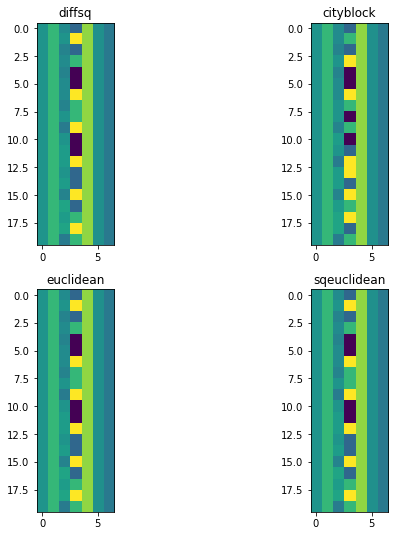

In [158]:
test = simdata[7000][1]

fig, ax = plt.subplots(2,2, figsize=(9,9))
axes = np.ravel(ax)
funcs = [diff_sq, scipy.spatial.distance.cityblock, scipy.spatial.distance.euclidean, scipy.spatial.distance.sqeuclidean]
names = ['diffsq', 'cityblock', 'euclidean', 'sqeuclidean']

for n in range(0,4):
    data = histcomp(test, simdata, funcs[n])
    axes[n].imshow(data[:20,:-1])
    axes[n].set_title(names[n])
    

In [120]:
b = histcomp(test, simdata, scipy.spatial.distance.cityblock)
c = pd.DataFrame(b)
c.columns = ['bg_mean', 'bg_var', 'blob_intensity_mean', 'blob_intensity_var', 'blob_radius_mean', 'blob_radius_var', 'blob_number', 'compscore']

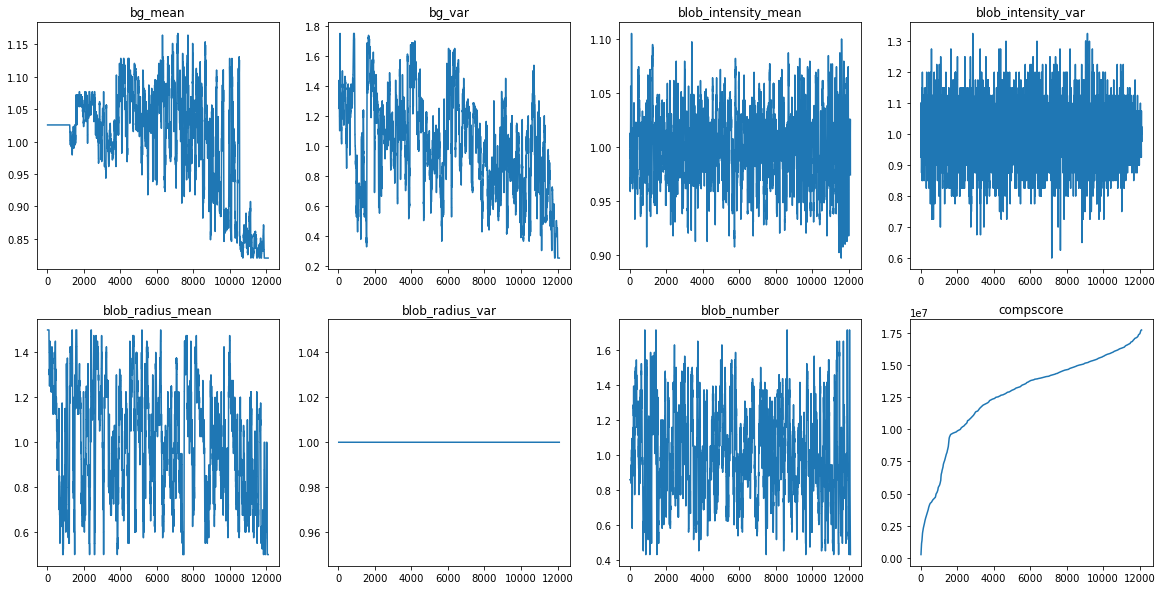

In [207]:
test = simdata[7000][1]
b = histcomp(test, simdata, scipy.spatial.distance.cityblock)
c = pd.DataFrame(b)
c.columns = ['bg_mean', 'bg_var', 'blob_intensity_mean', 'blob_intensity_var', 'blob_radius_mean', 'blob_radius_var', 'blob_number', 'compscore']
fig, ax = plt.subplots(2,4, figsize=(20,10))
axes = np.ravel(ax)

for n in range(0,8):
    axes[n].plot(c.iloc[:,n].rolling(20).mean())
    axes[n].set_title(c.columns[n])



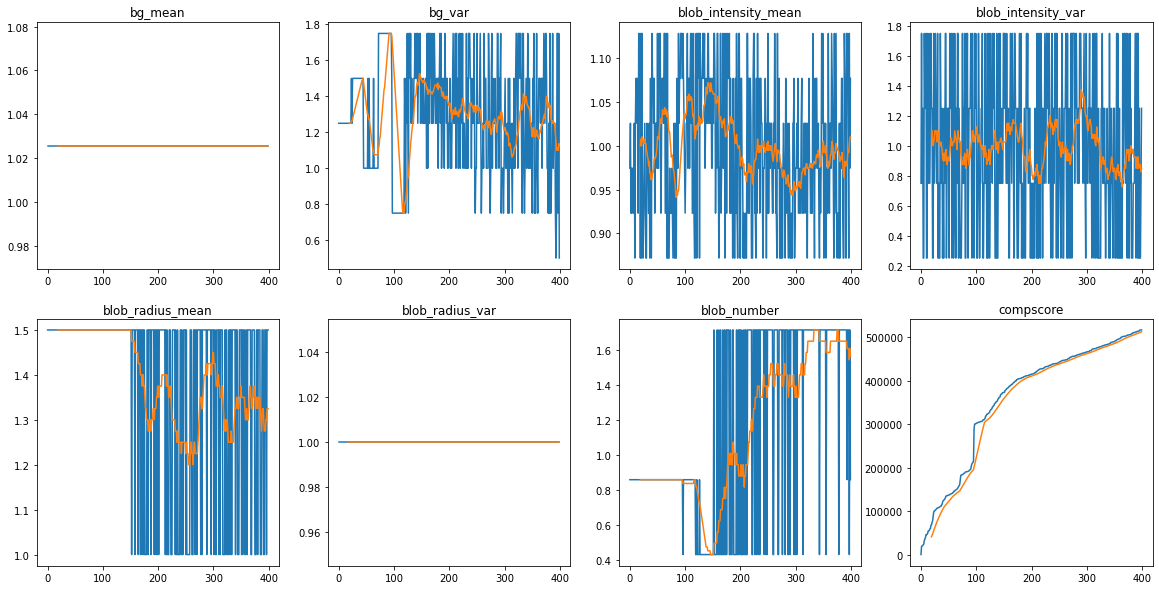

In [223]:
test = simdata[7000][1]
b = histcomp(test, simdata, scipy.spatial.distance.euclidean)
c = pd.DataFrame(b)
c.columns = ['bg_mean', 'bg_var', 'blob_intensity_mean', 'blob_intensity_var', 'blob_radius_mean', 'blob_radius_var', 'blob_number', 'compscore']
fig, ax = plt.subplots(2,4, figsize=(20,10))
axes = np.ravel(ax)

for n in range(0,8):
    axes[n].plot(c.iloc[:400,n])
    axes[n].plot(c.iloc[:400,n].rolling(20).mean())
    axes[n].set_title(c.columns[n])

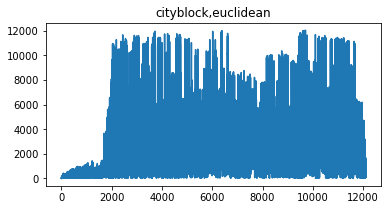

In [219]:
# Rank disagreement
test = simdata[3000][1]

fig, ax = plt.subplots(1,1, figsize=(6,3))
axes = np.ravel(ax)

funcs = [scipy.spatial.distance.cityblock, scipy.spatial.distance.euclidean]
names = ['cityblock', 'euclidean', 'sqeuclidean']
plotnum=0
for n in range(0, len(funcs)-1):
    for m in range(1, len(funcs)):
        #if (n != m):
            
        data1 = histcomp(test, simdata, funcs[n], sort=False)
        data2 = histcomp(test, simdata, funcs[m], sort=False)
        rankdif = abs(np.argsort(data1[:,-1]) - np.argsort(data2[:,-1]))
        axes[plotnum].plot(rankdif)
        axes[plotnum].set_title(names[n]+','+names[m])
        plotnum += 1

- Try both manhattan and city block and check to see if highest scoring models are the same. As long as they are, ::shrug::  

- For a dataset, we will end up with a bunch of models and scores. How do we evaluate? Examine the parameters of the top-scoring models?

- What about HLB? I think we have to mask them with some dilation to make sure they don't influence histograms.

In [2]:
stack = fm.read_czi('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/2021-09-10/20210910Rpb1EGFP_emb7_-07.czi', swapaxes=False)

In [252]:
mask = np.where(stack > 5000, 1, 0)
mask = ndi.morphology.binary_erosion(mask, np.ones((1,4,4)))
mask = ndi.morphology.binary_dilation(mask, np.ones((1,6,6)))
fm.viewer(mask)

interactive(children=(Dropdown(description='Color', options=('cividis', 'Greens', 'magma', 'Reds', 'gray', 'vi…

In [260]:
ss = fm.make_scalespace_representation(stack, sigmas=[0.25, 0.5, 0.75,1.0,1.5, 2])

In [261]:
fm.viewer(ss)

interactive(children=(Dropdown(description='Color', options=('cividis', 'Greens', 'magma', 'Reds', 'gray', 'vi…

In [268]:
ssh = fm.make_scalespace_2dhist(stack, [0.25, 0.5, 0.75,1.0,1.5, 2], mask, numbins=100, histrange=(5000, 25_000))

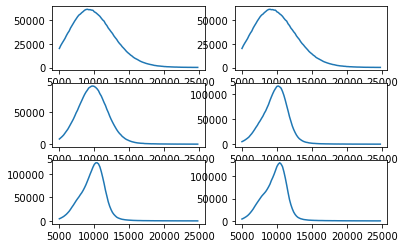

In [267]:
fig, ax = plt.subplots(3,2)
axes = np.ravel(ax)
for i in range(0, 6):
    axes[i].plot(np.arange(5000,25_000, 20_000/100), ssh[i])

In [242]:
fm.viewer(np.where(stack > 5000, stack, 0))

interactive(children=(Dropdown(description='Color', options=('cividis', 'Greens', 'magma', 'Reds', 'gray', 'vi…

On simulation, need to do a little work on how much mask size/nucleus number affects comp time and output.

Try a range of parameters, investigate histogram.

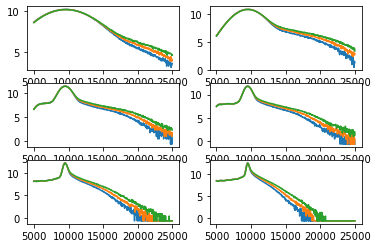

In [5]:
fig, ax = plt.subplots(3,2)
axes = np.ravel(ax)
for n in range(1,4):
    mask = fm.make_dummy_mask(zdim=100, idim=300, jdim=300, nuc_spacing=110, nuc_rad=50)
    sim = fm.simulate_blobs(mask, bg_mean=9500, bg_var=2600, blob_intensity_mean=12_000 + (n * 1000), 
        blob_intensity_var=1000, blob_radius_mean=2, blob_radius_var=0.5, blob_number=100 + (50 * n), 
        z_ij_ratio=2)
    ssh = fm.make_scalespace_2dhist(sim, [0.25, 0.5, 0.75,1.0,1.5, 2], mask, numbins=500, histrange=(5000, 25_000))
    ssh = np.log(ssh + 0.5)
    for i in range(0, 6):
        axes[i].plot(np.arange(5000,25_000, 20_000/500), ssh[i])


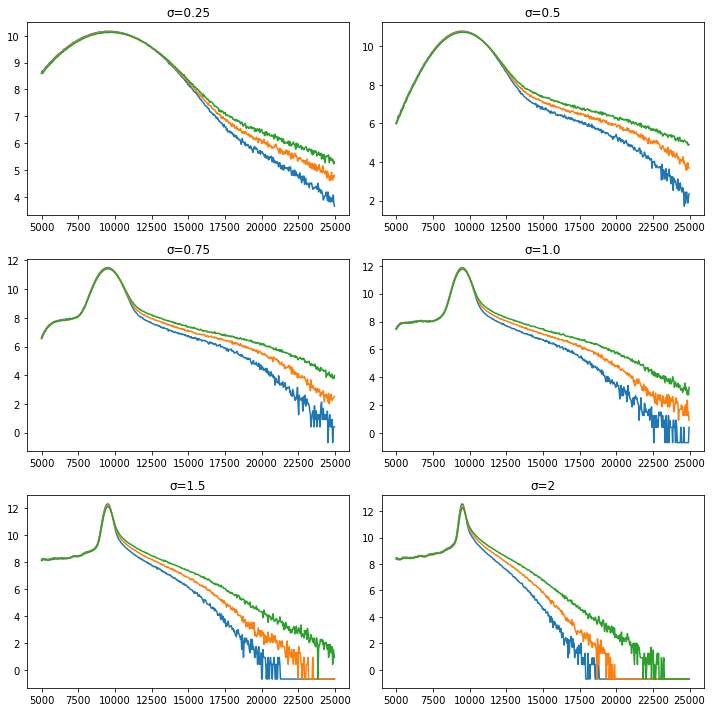

In [233]:
fig, ax = plt.subplots(3,2, figsize=(10,10))
axes = np.ravel(ax)
for n in range(1,4):
    mask = fm.make_dummy_mask(zdim=100, idim=300, jdim=300, nuc_spacing=110, nuc_rad=50)
    sim = fm.simulate_blobs(mask, bg_mean=9500, bg_var=2600, blob_intensity_mean=12_000 + (n *2000), 
        blob_intensity_var=1000, blob_radius_mean=2, blob_radius_var=0.5, blob_number=100 + (50 * n), 
        z_ij_ratio=2)
    ssh = fm.make_scalespace_2dhist(sim, [0.25, 0.5, 0.75,1.0,1.5, 2], mask, numbins=500, histrange=(5000, 25_000))
    ssh = np.log(ssh + 0.5)
    sigmas = [0.25, 0.5, 0.75,1.0,1.5, 2]
    for i in range(0, 6):
        axes[i].plot(np.arange(5000,25_000, 20_000/500), ssh[i])
        axes[i].set_title('σ=' + str(sigmas[i]))
    fig.tight_layout()

In [306]:
fm.viewer(sim)

interactive(children=(Dropdown(description='Color', options=('cividis', 'Greens', 'magma', 'Reds', 'gray', 'vi…

I think I need a slightly different paradigm. Before, I was sorta planning on simulating wide parameter ranges and finding the right ones by just trying a lot. But I now see that the combinatorics of that approach are tough, plus the way I'm modeling these things (gaussian distributions) may just not be correct, or may not match the real data. 

I think I need to step back and look at the simulation, particularly the distribution of nuclear background and the shape of spots.

Let's start with the background.

In [3]:
mask = fm.segment_nuclei_3Dstack_rpb1(stack)
maskf = fm.labelmask_filter_objsize(mask, 0, 300_000)
maskf = fm.filter_labelmask_circularity(maskf, 43, 0.5)

In [5]:
vals = stack[np.where(maskf > 0)]

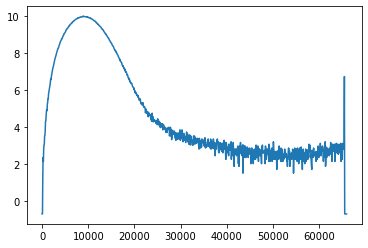

In [103]:
hist = np.histogram(vals,1000, (0,66_000))
plt.plot( hist[1][:-1], np.log(hist[0] + 0.5))

In [74]:
from scipy.stats import norm, beta

def tempnorm(mean_, sd_):
    x = np.linspace(norm.ppf(0.0001), norm.ppf(0.9999), 100)
    y = norm.pdf(x)
    x = (x * sd_) + mean_
    return x, y

def tempbeta(mean_, sd_, a, b):
    x = np.linspace(beta.ppf(0.0001, a, b), beta.ppf(0.9999, a, b), 100)
    y = norm.pdf(x)
    x = (x * sd_) + mean_
    return x, y    

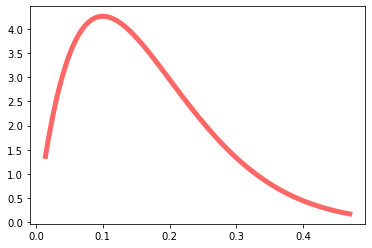

In [94]:
a, b = 2, 10
x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
plt.plot(x, beta.pdf(x, a, b),'r-', lw=5, alpha=0.6, label='beta pdf')

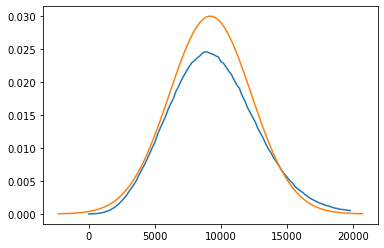

In [95]:
x, y = tempnorm(9_200, 3_100)
#x, y = tempbeta(9_200, 3_100, 10, 10)
y1 = y / np.sum(y)

x2 = hist[1][:-1]
y2 = hist[0]
y2 = y2/ np.sum(y2)

plt.plot(x2, y2);
plt.plot(x, y1)

In [71]:
np.sum(y2)

1.0

OK, it looks like gaussians are actually totally fine, both for background and for blobs. The log of the scale-space histogram is certainly an improvement. I need to mask HLBs in some aggressive way...

Quickly return to the timing question I started with

In [144]:
np.apply_along_axis(lambda x: x / np.sum(x), 1, ssh)


1.0

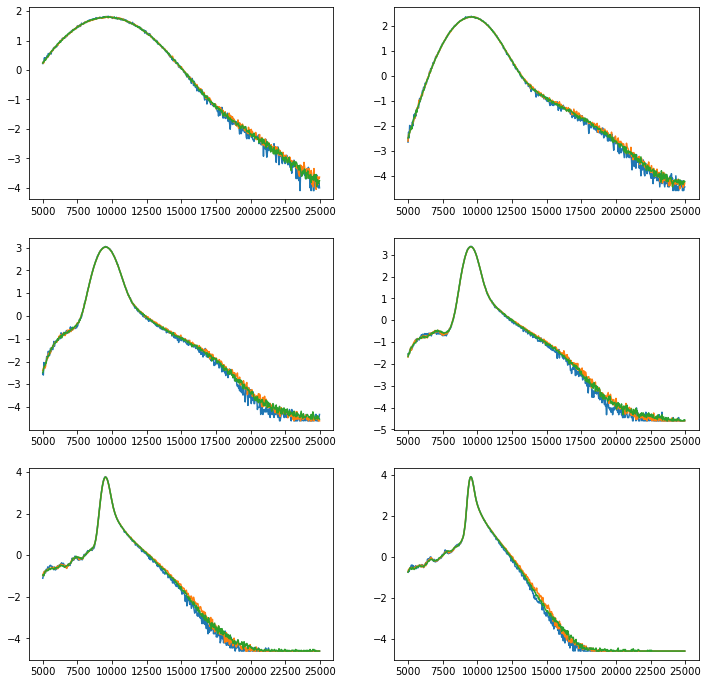

In [214]:
fig, ax = plt.subplots(3,2, figsize=(12,12))
axes = np.ravel(ax)
sizes=[
    #[20, 100, 100],
    [20, 200, 200],
    [20, 300, 300],
    [20, 400, 400]
    #[40, 300, 300],
]
for n in range(0, len(sizes)):
    mask = fm.make_dummy_mask(zdim=sizes[n][0], idim=sizes[n][1], jdim=sizes[n][2], nuc_spacing=100, nuc_rad=50)
    sim = fm.simulate_blobs(mask, bg_mean=9500, bg_var=2600, blob_intensity_mean=12_000, 
        blob_intensity_var=1000, blob_radius_mean=2, blob_radius_var=0.5, blob_number=100, 
        z_ij_ratio=2)
    ssh = fm.make_scalespace_2dhist(sim, [0.25, 0.5, 0.75,1.0,1.5, 2], mask, numbins=500, histrange=(5000, 25_000))
    ssh = np.apply_along_axis(lambda x: x / np.sum(x), 1, ssh) * 1000 # Normalize rows to sum to 1.
    ssh = np.log(ssh + 0.01)
    for i in range(0, 6):
        axes[i].plot(np.arange(5000,25_000, 20_000/500), ssh[i])

In [222]:
mask = fm.make_dummy_mask(zdim=40, idim=800, jdim=800, nuc_spacing=200, nuc_rad=50)

In [223]:
%%time
sim = fm.simulate_blobs(mask, bg_mean=9500, bg_var=2600, blob_intensity_mean=12_000, 
        blob_intensity_var=1000, blob_radius_mean=2, blob_radius_var=0.5, blob_number=100, 
        z_ij_ratio=2)
ssh = fm.make_scalespace_2dhist(sim, [0.25, 0.5, 0.75,1.0,1.5, 2], mask, numbins=500, histrange=(5000, 25_000))
ssh = np.apply_along_axis(lambda x: x / np.sum(x), 1, ssh) * 1000 # Normalize rows to sum to 1.
ssh = np.log(ssh + 0.01)

CPU times: user 6.99 s, sys: 255 ms, total: 7.24 s
Wall time: 7.27 s


In [225]:
7270/280

25.964285714285715

5.555555555555555